# Atlantic sector: DIC, NO3, Fe, NPP: meridional distribution

In [ ]:
# Not needed for B-SOSE

# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session

import s3fs

In [ ]:
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests

import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import numpy as np
import pandas as pd
import calendar
import gsw
#import warnings

In [ ]:
#warnings.filterwarnings("ignore")

In [ ]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:42155")
client.ncores
client.restart()

In [5]:
# Plotting settings

plt.rcParams['figure.figsize'] = (10, 3)

In [6]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# show first 20 files
print('\nFirst 20 files')
pprint([x.name for x in bsose_files[:20]])


First 20 files
['ADVrDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVr_SLT_bsoseI156_2013to2024_monthly.nc',
 'ADVr_TH_bsoseI156_2013to2024_monthly.nc',
 'ADVxDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVyDIC_bsoseI156_2013to2024_monthly.nc',
 'DIC_bsoseI156_2013to2024_monthly.nc',
 'Fe_bsoseI156_2013to2024_monthly.nc',
 'MLD_bsoseI156_2013to2024_monthly.nc',
 'NO3_bsoseI156_2013to2024_monthly.nc',
 'NPP_bsoseI156_2013to2024_monthly.nc',
 'Salt_bsoseI156_2013to2024_monthly.nc',
 'Theta_bsoseI156_2013to2024_monthly.nc',
 'WVELSLT_bsoseI156_2013to2024_monthly.nc',
 'WVELTH_bsoseI156_2013to2024_monthly.nc',
 'Wvel_bsoseI156_2013to2024_monthly.nc',
 'grid.nc',
 'surfCO2flx_bsoseI156_2013to2024_monthly.nc']


In [7]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# open dataset
MLD_file = bsose_path / 'MLD_bsoseI156_2013to2024_monthly.nc'
theta_file = bsose_path / 'Theta_bsoseI156_2013to2024_monthly.nc'
salt_file = bsose_path / 'Salt_bsoseI156_2013to2024_monthly.nc'
Fe_file = bsose_path / 'Fe_bsoseI156_2013to2024_monthly.nc'
DIC_file = bsose_path / 'DIC_bsoseI156_2013to2024_monthly.nc'
NO3_file = bsose_path / 'NO3_bsoseI156_2013to2024_monthly.nc'
NPP_file = bsose_path / 'NPP_bsoseI156_2013to2024_monthly.nc'
surfCO2flx_file = bsose_path / 'surfCO2flx_bsoseI156_2013to2024_monthly.nc'
grid_file = bsose_path / 'grid.nc'

In [8]:
# start timer
start_time = time.time()

# load the file into memory (note 'load' command at the end)
ds = xr.open_dataset(theta_file)
salt_ds = xr.open_dataset(salt_file)
DIC_ds = xr.open_dataset(DIC_file)
Fe_ds = xr.open_dataset(Fe_file)
NO3_ds = xr.open_dataset(NO3_file)
NPP_ds = xr.open_dataset(NPP_file)
MLD_ds = xr.open_dataset(MLD_file)
surfCO2flx_ds = xr.open_dataset(surfCO2flx_file)
grid_ds = xr.open_dataset(grid_file)

# stop timer
total_time = time.time() - start_time

print('\nloaded theta')
print(f'total time {total_time:.2f} sec')
print('time level : ' , ds.time.values[0])


loaded theta
total time 9.12 sec
time level :  2013-01-30T20:00:00.000000000


### Vertical mean and ML mean

In [9]:
def compute_vert_mean(ds, var):
    """
    Compute vertical mean.

    Parameters:
        ds (xr.Dataset): Dataset containing the mask and the dimensions
        var (str): Variable.

    Returns:
        xr.DataArray: variable avg in the vertical [time, YC, XC]
    """

    time_len = ds.dims['time']
    YC = ds.dims['YC']
    XC = ds.dims['XC']

    var_vertmean = np.full((time_len, YC, XC), np.nan)

    for ti in range(time_len):
        var_t = var.isel(time=ti)   # 3D: [Z, YC, XC]

        # Apply spatial mask to final field
        #var_t_masked = var_t.where(ds.maskC)
        var_t_masked = var_t.where(ds.maskC,np.nan)
        var_vertmean[ti, :, :] = var_t_masked.mean(dim='Z', skipna=True)

    return xr.DataArray(
        var_vertmean,
        coords={
            'time': ds.coords['time'],
            'YC': ds.coords['YC'],
            'XC': ds.coords['XC']
        },
        dims=["time", "YC", "XC"]
    )


def compute_ML_mean(ds, MLD_ds, var):
    """
    Compute mixed layer mean.

    Parameters:
        ds (xr.Dataset): Dataset containing the mask and the dimensions
        MLD_ds (xr.Dataset): Dataset containing mixed layer depth (MLD).
        var (str): Variable.

    Returns:
        xr.DataArray: variable avg in the ML [time, YC, XC]
    """

    time_len = ds.dims['time']
    YC = ds.dims['YC']
    XC = ds.dims['XC']

    var_ML = np.full((time_len, YC, XC), np.nan)

    for ti in range(time_len):
        MLD_t = MLD_ds.BLGMLD.isel(time=ti)  # 2D: [YC, XC]
        var_t = var.isel(time=ti)   # 3D: [Z, YC, XC]

        # Mask the levels where depth is shallower than MLD
        var_ML_t = np.nanmean(var_t.where(-ds.Z < MLD_t), axis=0)  # 2D

        # Apply spatial mask to final field
        var_ML[ti, :, :] = np.where(ds.maskInC, var_ML_t, np.nan)

    return xr.DataArray(
        var_ML,
        coords={
            'time': ds.coords['time'],
            'YC': ds.coords['YC'],
            'XC': ds.coords['XC']
        },
        dims=["time", "YC", "XC"]
    )

In [10]:
warnings.filterwarnings("ignore")

theta_vertmean = compute_vert_mean(ds, ds.THETA)
DIC_vertmean = compute_vert_mean(ds, DIC_ds.TRAC01)
NO3_vertmean = compute_vert_mean(ds, NO3_ds.TRAC04)
Fe_vertmean = compute_vert_mean(ds, Fe_ds.TRAC06)
NPP_vertmean = compute_vert_mean(ds, NPP_ds.BLGNPP)

theta_ML = compute_ML_mean(ds, MLD_ds, ds.THETA)
DIC_ML = compute_ML_mean(ds, MLD_ds, DIC_ds.TRAC01)
NO3_ML = compute_ML_mean(ds, MLD_ds, NO3_ds.TRAC04)
Fe_ML = compute_ML_mean(ds, MLD_ds, Fe_ds.TRAC06)
NPP_ML = compute_ML_mean(ds, MLD_ds, NPP_ds.BLGNPP)

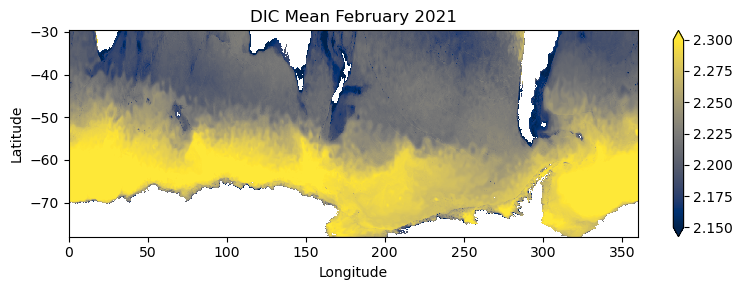

In [131]:
plt.figure(figsize=(8, 3))

ti=97 # feb 2021
#ti=103 # aug 2021
var = DIC_vertmean[ti,:,:]

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

vmin=2.15
vmax=2.3
plt.pcolormesh(ds.XC, ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='cividis')
#plt.pcolormesh(ds.XC, ds.YC, var, shading='auto', cmap='cividis')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'DIC Mean {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/DIC_vertmean_map.png", dpi=300, bbox_inches='tight')

plt.show()

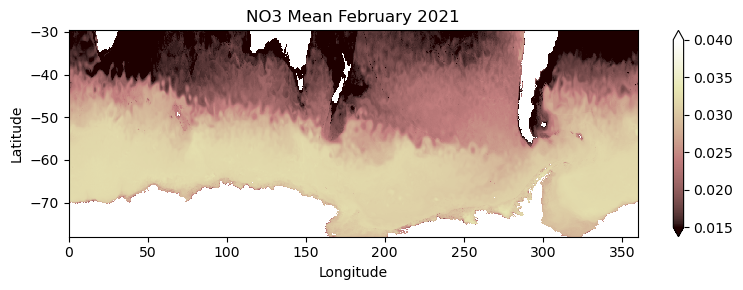

In [149]:
plt.figure(figsize=(8, 3))

ti=97 # feb 2021
#ti=103 # aug 2021
var = NO3_vertmean[ti,:,:]

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

vmin=0.015
vmax=0.04
plt.pcolormesh(ds.XC, ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='pink')
#plt.pcolormesh(ds.XC, ds.YC, var, shading='auto', cmap='hot')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'NO3 Mean {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/NO3_vertmean_map.png", dpi=300, bbox_inches='tight')

plt.show()

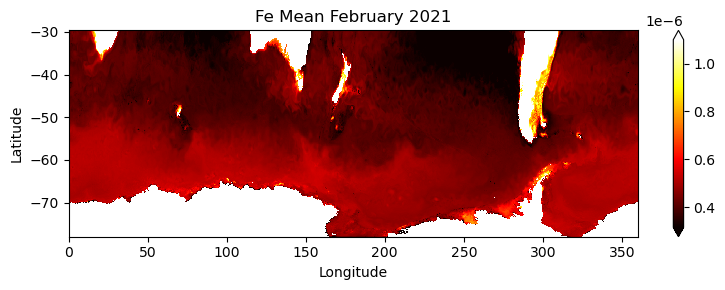

In [174]:
plt.figure(figsize=(8, 3))

ti=97 # feb 2021
#ti=103 # aug 2021
var = Fe_vertmean[ti,:,:]

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

vmin=1.1e-6
vmax=0.35e-6
plt.pcolormesh(ds.XC, ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='hot')
#plt.pcolormesh(ds.XC, ds.YC, var, shading='auto', cmap='hot')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Fe Mean {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/Fe_vertmean_map.png", dpi=300, bbox_inches='tight')

plt.show()

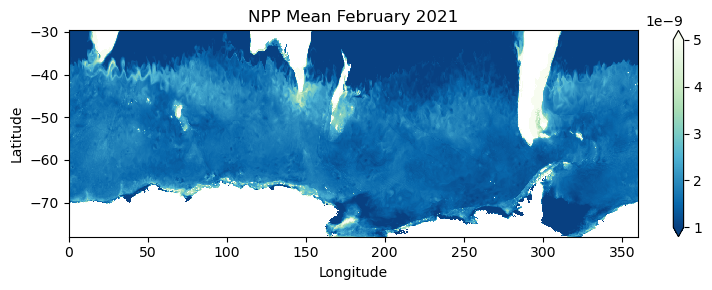

In [189]:
plt.figure(figsize=(8, 3))

ti=97 # feb 2021
#ti=103 # aug 2021
var = NPP_vertmean[ti,:,:]

time_str = pd.to_datetime(ds.time[ti].values).strftime('%B %Y')

vmin=0.1e-8
vmax=0.5e-8
plt.pcolormesh(ds.XC, ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='GnBu_r')
#plt.pcolormesh(ds.XC, ds.YC, var, shading='auto', cmap='GnBu_r')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'NPP Mean {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/NPP_vertmean_map.png", dpi=300, bbox_inches='tight')

plt.show()

### Atlantic sector meridional concentration

In [12]:
# Define Atlantic sector

box_lon_min, box_lon_max = 300, 360     
box_lat_min, box_lat_max = ds.YC[0].values, ds.YC[-1].values

In [13]:
def compute_var_box(ds, var, box_lon_min, box_lon_max, box_lat_min, box_lat_max):
    """
    Compute seasonal climatology and anomaly of DIC in a spatial box averaged over longitude.

    Parameters:
        ds (xr.Dataset): Dataset with maskC and coordinates
        var (variable): variable
        box_lon_min, box_lon_max: Longitude bounds
        box_lat_min, box_lat_max: Latitude bounds

    Returns:
        tuple: (var_box, var_box_clim, var_box_winter, var_box_summer, var_box_seasonal_anomaly)
    """

    # Initialize result array
    var_box_masked = xr.DataArray(
        np.full((ds.dims['time'], ds.dims['Z'], ds.dims['YC']), np.nan),
        coords={
            'time': ds.coords['time'],
            'Z': ds.coords['Z'],
            'YC': ds.coords['YC']
        },
        dims=["time", "Z", "YC"]
    )

    mask_box = ds.maskC.sel(XC=slice(box_lon_min, box_lon_max),
            YC=slice(box_lat_min, box_lat_max))
    var_box = var.sel(XC=slice(box_lon_min, box_lon_max),
            YC=slice(box_lat_min, box_lat_max))
    
    # Loop over time to apply mask and slice box
    for ti in range(ds.dims['time']):
        var_mask = var_box.isel(time=ti).where(mask_box, np.nan)
        var_box_masked[ti, :, :] = var_mask.mean(dim='XC', skipna=True)

    # Monthly climatology
    var_box_clim = var_box_masked.groupby("time.month").mean("time", skipna=True)

    # Rename month to abbreviations
    month_names = [calendar.month_abbr[m] for m in var_box_clim["month"].values]
    var_box_clim = var_box_clim.assign_coords(month=("month", month_names))

    # Winter: June–August (Southern Hemisphere)
    var_box_winter = var_box_clim.sel(month=["Jun", "Jul", "Aug"]).mean(dim="month", skipna=True)

    # Summer: December–February
    var_box_summer = var_box_clim.sel(month=["Dec", "Jan", "Feb"]).mean(dim="month", skipna=True)

    # Anomaly: winter - summer
    var_box_seasonal_anomaly = var_box_winter - var_box_summer

    return var_box, var_box_clim, var_box_winter, var_box_summer, var_box_seasonal_anomaly

In [14]:
def compute_var2D_box(ds, var, box_lon_min, box_lon_max, box_lat_min, box_lat_max):
    """
    Compute seasonal climatology and anomaly of DIC in a spatial box averaged over longitude.

    Parameters:
        ds (xr.Dataset): Dataset with maskC and coordinates
        var (variable): variable
        box_lon_min, box_lon_max: Longitude bounds
        box_lat_min, box_lat_max: Latitude bounds

    Returns:
        tuple: (var_box, var_box_clim, var_box_winter, var_box_summer, var_box_seasonal_anomaly)
    """

    # Initialize result array
    var_box_masked = xr.DataArray(
        np.full((ds.dims['time'], ds.dims['YC']), np.nan),
        coords={
            'time': ds.coords['time'],
            'YC': ds.coords['YC']
        },
        dims=["time", "YC"]
    )

    mask_box = ds.maskInC.sel(XC=slice(box_lon_min, box_lon_max),
            YC=slice(box_lat_min, box_lat_max))
    var_box = var.sel(XC=slice(box_lon_min, box_lon_max),
            YC=slice(box_lat_min, box_lat_max))
    
    # Loop over time to apply mask and slice box
    for ti in range(ds.dims['time']):
        var_mask = var_box.isel(time=ti).where(mask_box, np.nan)
        var_box_masked[ti, :] = var_mask.mean(dim='XC', skipna=True)

    # Monthly climatology
    var_box_clim = var_box_masked.groupby("time.month").mean("time", skipna=True)

    # Rename month to abbreviations
    month_names = [calendar.month_abbr[m] for m in var_box_clim["month"].values]
    var_box_clim = var_box_clim.assign_coords(month=("month", month_names))

    # Winter: June–August (Southern Hemisphere)
    var_box_winter = var_box_clim.sel(month=["Jun", "Jul", "Aug"]).mean(dim="month", skipna=True)

    # Summer: December–February
    var_box_summer = var_box_clim.sel(month=["Dec", "Jan", "Feb"]).mean(dim="month", skipna=True)

    # Anomaly: winter - summer
    var_box_seasonal_anomaly = var_box_winter - var_box_summer

    return var_box, var_box_clim, var_box_winter, var_box_summer, var_box_seasonal_anomaly

In [15]:
[DIC_box,DIC_box_clim,DIC_box_winter,DIC_box_summer,DIC_box_seasonal_anomaly]=compute_var_box(
    ds,DIC_ds.TRAC01,box_lon_min,box_lon_max,box_lat_min,box_lat_max)

In [16]:
[NO3_box, NO3_box_clim, NO3_box_winter, NO3_box_summer, NO3_box_seasonal_anomaly] = compute_var_box(
    ds, NO3_ds.TRAC04, box_lon_min, box_lon_max, box_lat_min, box_lat_max)

In [17]:
[Fe_box, Fe_box_clim, Fe_box_winter, Fe_box_summer, Fe_box_seasonal_anomaly] = compute_var_box(
    ds, Fe_ds.TRAC06, box_lon_min, box_lon_max, box_lat_min, box_lat_max)

In [18]:
[NPP_box, NPP_box_clim, NPP_box_winter, NPP_box_summer, NPP_box_seasonal_anomaly] = compute_var_box(
    ds, NPP_ds.BLGNPP, box_lon_min, box_lon_max, box_lat_min, box_lat_max)

In [19]:
[MLD_box, MLD_box_clim, MLD_box_winter, MLD_box_summer, MLD_box_seasonal_anomaly] = compute_var2D_box(
    ds, MLD_ds.BLGMLD, box_lon_min, box_lon_max, box_lat_min, box_lat_max)

### Figures for the Atlantic sector

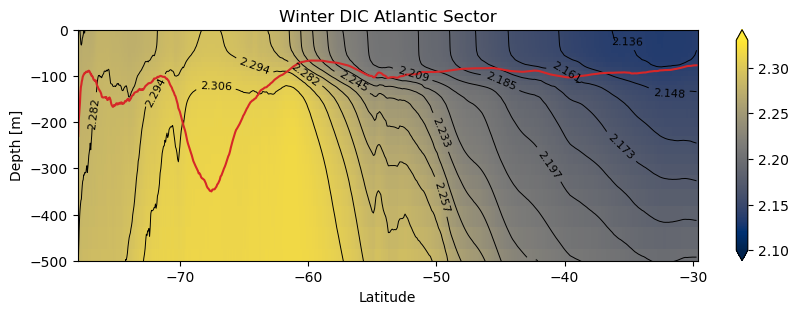

In [22]:
plt.figure()

var = DIC_box_winter

vmax = 2.33
vmin = 2.1
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='cividis')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter DIC Atlantic Sector')
plt.ylim(-500,0)

# Add contour lines
contour_levels = np.linspace(vmin, vmax, 20)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

# Add MLD
plt.plot(ds.YC,-MLD_box_winter,color='tab:red')

plt.savefig(f"figures_anna/DIC_winter_atl_MLD.png", dpi=300, bbox_inches='tight')

plt.show()

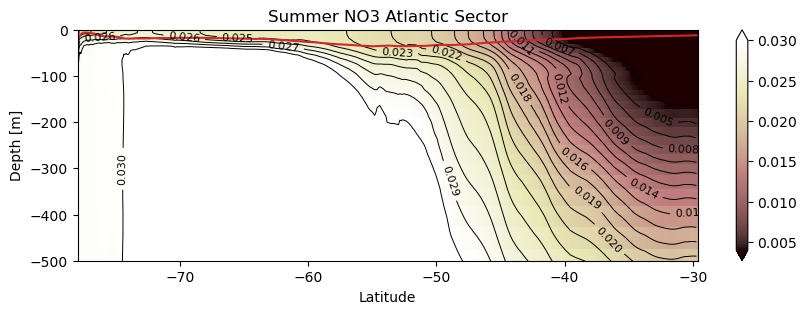

In [42]:
plt.figure()

var = NO3_box_summer

vmax = 0.03
vmin = 0.004
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='pink')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Summer NO3 Atlantic Sector')
plt.ylim(-500,0)

# Add contour lines
contour_levels = np.linspace(vmin, vmax, 20)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

# Add MLD
plt.plot(ds.YC,-MLD_box_summer,color='tab:red')

plt.savefig(f"figures_anna/NO3_summer_atl_MLD.png", dpi=300, bbox_inches='tight')

plt.show()

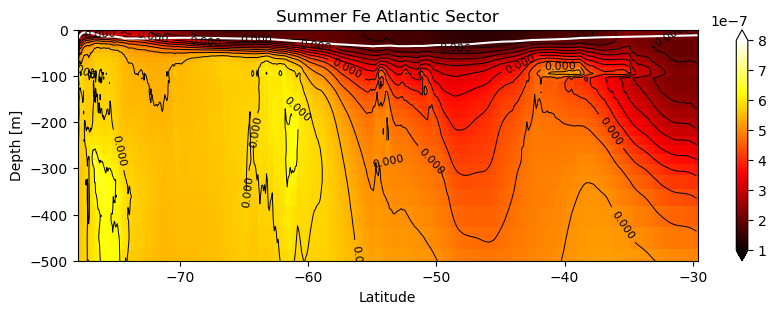

In [98]:
plt.figure()

var = Fe_box_summer

vmax = 0.8e-6
vmin = 0.1e-6
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='hot')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Summer Fe Atlantic Sector')
plt.ylim(-500,0)

# Add contour lines
contour_levels = np.linspace(vmin, vmax, 20)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

# Add MLD
plt.plot(ds.YC,-MLD_box_summer,color='w')

plt.savefig(f"figures_anna/Fe_summer_atl_MLD.png", dpi=300, bbox_inches='tight')

plt.show()

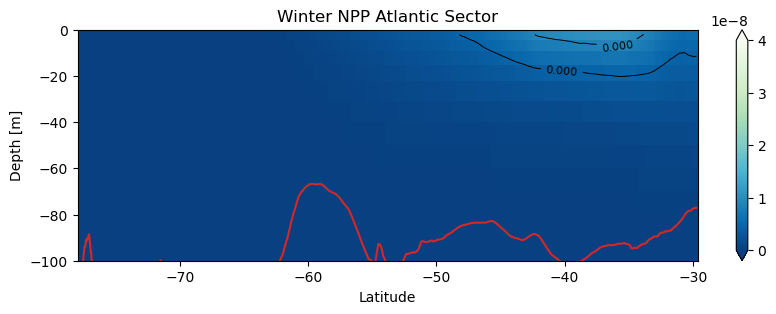

In [62]:
plt.figure()

var = NPP_box_winter

vmax = 4e-8
vmin = 0
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='GnBu_r')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter NPP Atlantic Sector')
plt.ylim(-100,0)

# Add contour lines
contour_levels = np.linspace(vmin, vmax, 10)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

# Add MLD
plt.plot(ds.YC,-MLD_box_winter,color='tab:red')

plt.savefig(f"figures_anna/NPP_winter_atl_MLD.png", dpi=300, bbox_inches='tight')

plt.show()

### Seasonality

In [84]:
MLD_box_seas = MLD_box_clim.mean(dim='YC',skipna=True)

In [20]:
DIC_box_seas = DIC_box_clim.mean(dim='Z',skipna=True).mean(dim='YC',skipna=True)
NO3_box_seas = NO3_box_clim.mean(dim='Z',skipna=True).mean(dim='YC',skipna=True)
Fe_box_seas = Fe_box_clim.mean(dim='Z',skipna=True).mean(dim='YC',skipna=True)
NPP_box_seas = NPP_box_clim.mean(dim='Z',skipna=True).mean(dim='YC',skipna=True)

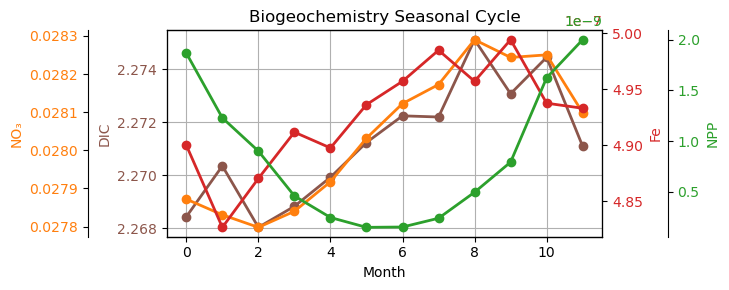

In [98]:
fig, ax_dic = plt.subplots(figsize=(8, 3))

# 1. DIC - Left y-axis (main)
ax_dic.plot(DIC_box_seas, label='DIC', color='tab:brown', marker='o', linewidth=2)
ax_dic.set_ylabel('DIC', color='tab:brown')
ax_dic.tick_params(axis='y', labelcolor='tab:brown')
ax_dic.set_xlabel('Month')
ax_dic.grid(True)

# 2. NO3 - Secondary left y-axis
ax_no3 = ax_dic.twinx()
ax_no3.spines["left"].set_position(("axes", -0.18))  # Shift left
ax_no3.plot(NO3_box_seas, label='NO₃', color='tab:orange', marker='o', linewidth=2)
ax_no3.set_ylabel('NO₃', color='tab:orange')
ax_no3.tick_params(axis='y', labelcolor='tab:orange')
ax_no3.yaxis.set_label_position('left')
ax_no3.yaxis.set_ticks_position('left')

# 3. Fe - Right y-axis
ax_fe = ax_dic.twinx()
ax_fe.plot(Fe_box_seas, label='Fe', color='tab:red', marker='o', linewidth=2)
ax_fe.set_ylabel('Fe', color='tab:red')
ax_fe.tick_params(axis='y', labelcolor='tab:red')

# 4. NPP - Secondary right y-axis (further right)
ax_npp = ax_dic.twinx()
ax_npp.spines["right"].set_position(("axes", 1.15))  # Shift right
ax_npp.plot(NPP_box_seas, label='NPP', color='tab:green', marker='o', linewidth=2)
ax_npp.set_ylabel('NPP', color='tab:green')
ax_npp.tick_params(axis='y', labelcolor='tab:green')

# Legend (gather lines from all axes)
lines = (
    ax_dic.get_lines()
    + ax_no3.get_lines()
    + ax_fe.get_lines()
    + ax_npp.get_lines()
)
labels = [line.get_label() for line in lines]
#fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.title("Biogeochemistry Seasonal Cycle")
fig.tight_layout()

plt.savefig(f"figures_anna/bgc_seasonal_cycle_atl.png", dpi=300, bbox_inches='tight')

plt.show()

### Saving variables

In [106]:
DIC_box.nbytes*1e-9

6.34023936

In [ ]:
# Combine variables into a dataset
ds_to_save = xr.Dataset({
    "DIC_vertmean": DIC_vertmean,
    "NO3_vertmean": NO3_vertmean,
    "Fe_vertmean": Fe_vertmean,
    "NPP_vertmean": NPP_vertmean,
    "DIC_ML": DIC_ML,
    "NO3_ML": NO3_ML,
    "Fe_ML": Fe_ML,
    "NPP_ML": NPP_ML,
    "DIC_box": DIC_box,
    "NO3_box": NO3_box,
    "Fe_box": Fe_box,
    "NPP_box": NPP_box,
    "DIC_box_clim": DIC_box_clim,
    "NO3_box_clim": NO3_box_clim,
    "Fe_box_clim": Fe_box_clim,
    "NPP_box_clim": NPP_box_clim,
    "DIC_box_winter": DIC_box_winter,
    "NO3_box_winter": NO3_box_winter,
    "Fe_box_winter": Fe_box_winter,
    "NPP_box_winter": NPP_box_winter,
    "DIC_box_summer": DIC_box_summer,
    "NO3_box_summer": NO3_box_summer,
    "Fe_box_summer": Fe_box_summer
 })

# Save to NetCDF file
#ds_to_save.to_netcdf("output/bgc_means.nc")

### Time series

In [28]:
MLD_box_timeseries = MLD_box.mean(dim='YC',skipna=True).mean(dim='XC',skipna=True)

DIC_box_timeseries = DIC_vertmean.sel(XC=slice(box_lon_min, box_lon_max),
            YC=slice(box_lat_min, box_lat_max)).mean(dim='YC',skipna=True).mean(dim='XC',skipna=True)

NO3_box_timeseries = NO3_vertmean.sel(XC=slice(box_lon_min, box_lon_max),
            YC=slice(box_lat_min, box_lat_max)).mean(dim='YC',skipna=True).mean(dim='XC',skipna=True)

Fe_box_timeseries = Fe_vertmean.sel(XC=slice(box_lon_min, box_lon_max),
            YC=slice(box_lat_min, box_lat_max)).mean(dim='YC',skipna=True).mean(dim='XC',skipna=True)

NPP_box_timeseries = NPP_vertmean.sel(XC=slice(box_lon_min, box_lon_max),
            YC=slice(box_lat_min, box_lat_max)).mean(dim='YC',skipna=True).mean(dim='XC',skipna=True)

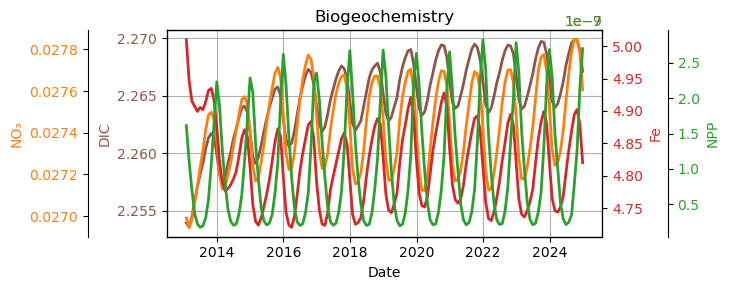

In [92]:
fig, ax_dic = plt.subplots(figsize=(8, 3))

# 1. DIC - Left y-axis (main)
ax_dic.plot(ds.time, DIC_box_timeseries, label='DIC', color='tab:brown', linewidth=2)
ax_dic.set_ylabel('DIC', color='tab:brown')
ax_dic.tick_params(axis='y', labelcolor='tab:brown')
ax_dic.set_xlabel('Date')
ax_dic.grid(True)

# 2. NO3 - Secondary left y-axis
ax_no3 = ax_dic.twinx()
ax_no3.spines["left"].set_position(("axes", -0.18))  # Shift left
ax_no3.plot(ds.time,NO3_box_timeseries, label='NO₃', color='tab:orange', linewidth=2)
ax_no3.set_ylabel('NO₃', color='tab:orange')
ax_no3.tick_params(axis='y', labelcolor='tab:orange')
ax_no3.yaxis.set_label_position('left')
ax_no3.yaxis.set_ticks_position('left')

# 3. Fe - Right y-axis
ax_fe = ax_dic.twinx()
ax_fe.plot(ds.time,Fe_box_timeseries, label='Fe', color='tab:red', linewidth=2)
ax_fe.set_ylabel('Fe', color='tab:red')
ax_fe.tick_params(axis='y', labelcolor='tab:red')

# 4. NPP - Secondary right y-axis (further right)
ax_npp = ax_dic.twinx()
ax_npp.spines["right"].set_position(("axes", 1.15))  # Shift right
ax_npp.plot(ds.time,NPP_box_timeseries, label='NPP', color='tab:green', linewidth=2)
ax_npp.set_ylabel('NPP', color='tab:green')
ax_npp.tick_params(axis='y', labelcolor='tab:green')

# Legend (gather lines from all axes)
lines = (
    ax_dic.get_lines()
    + ax_no3.get_lines()
    + ax_fe.get_lines()
    + ax_npp.get_lines()
)
labels = [line.get_label() for line in lines]
#fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.title("Biogeochemistry")
fig.tight_layout()

plt.savefig(f"figures_anna/bgc_timeseries_atl.png", dpi=300, bbox_inches='tight')

plt.show()

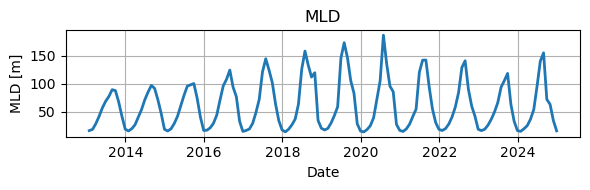

In [90]:
plt.figure(figsize=(6, 2))

plt.plot(ds.time, MLD_box_timeseries, label='MLD', color='tab:blue', linewidth=2)
plt.ylabel('MLD [m]')
plt.xlabel('Date')
plt.grid(True)
plt.title("MLD")
plt.tight_layout()

# Save figure if needed
plt.savefig("figures_anna/MLD_timeseries_atl.png", dpi=300, bbox_inches='tight')

plt.show()

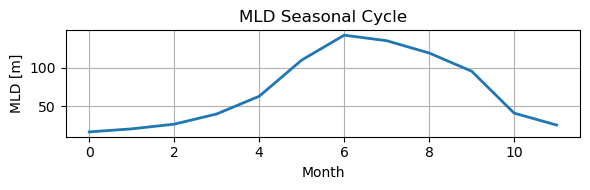

In [87]:
plt.figure(figsize=(6, 2))

plt.plot(MLD_box_seas, label='MLD', color='tab:blue', linewidth=2)
plt.ylabel('MLD [m]')
plt.xlabel('Month')
plt.grid(True)
plt.title("MLD Seasonal Cycle")
plt.tight_layout()

# Save figure if needed
plt.savefig("figures_anna/MLD_seas_atl.png", dpi=300, bbox_inches='tight')

plt.show()

### Interannual variability

In [55]:
time = ds.time
MLD_box_timeseries_time = xr.DataArray(MLD_box_timeseries, coords=[time], dims=['time'])
MLD_box_clim_time = MLD_box_timeseries_time.groupby("time.month").mean("time")
MLD_interannual = MLD_box_timeseries_time.groupby("time.month") - MLD_box_clim_time

In [49]:
DIC_box_timeseries_time = xr.DataArray(DIC_box_timeseries, coords=[time], dims=['time'])
DIC_box_clim_time = DIC_box_timeseries_time.groupby("time.month").mean("time")
DIC_interannual = DIC_box_timeseries_time.groupby("time.month") - DIC_box_clim_time

In [50]:
NO3_box_timeseries_time = xr.DataArray(NO3_box_timeseries, coords=[time], dims=['time'])
NO3_box_clim_time = NO3_box_timeseries_time.groupby("time.month").mean("time")
NO3_interannual = NO3_box_timeseries_time.groupby("time.month") - NO3_box_clim_time

In [51]:
Fe_box_timeseries_time = xr.DataArray(Fe_box_timeseries, coords=[time], dims=['time'])
Fe_box_clim_time = Fe_box_timeseries_time.groupby("time.month").mean("time")
Fe_interannual = Fe_box_timeseries_time.groupby("time.month") - Fe_box_clim_time

In [52]:
NPP_box_timeseries_time = xr.DataArray(NPP_box_timeseries, coords=[time], dims=['time'])
NPP_box_clim_time = NPP_box_timeseries_time.groupby("time.month").mean("time")
NPP_interannual = NPP_box_timeseries_time.groupby("time.month") - NPP_box_clim_time

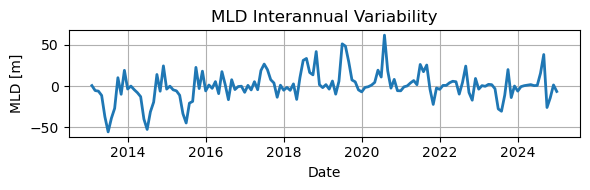

In [89]:
plt.figure(figsize=(6, 2))

plt.plot(ds.time, MLD_interannual, label='MLD', color='tab:blue', linewidth=2)
plt.ylabel('MLD [m]')
plt.xlabel('Date')
plt.grid(True)
plt.title("MLD Interannual Variability")
plt.tight_layout()

# Save figure if needed
plt.savefig("figures_anna/MLD_interannual_atl.png", dpi=300, bbox_inches='tight')

plt.show()

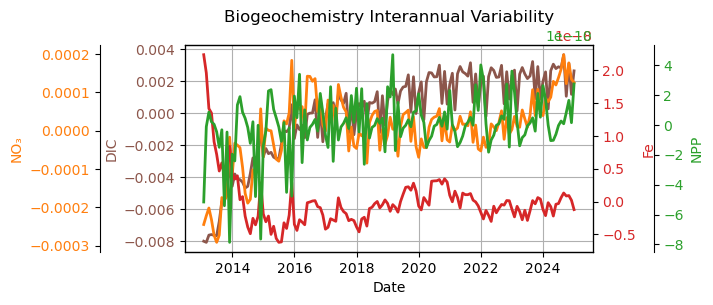

In [91]:
fig, ax_dic = plt.subplots(figsize=(8, 3))

# 1. DIC - Left y-axis (main)
ax_dic.plot(ds.time, DIC_interannual, label='DIC', color='tab:brown', linewidth=2)
ax_dic.set_ylabel('DIC', color='tab:brown')
ax_dic.tick_params(axis='y', labelcolor='tab:brown')
ax_dic.set_xlabel('Date')
ax_dic.grid(True)

# 2. NO3 - Secondary left y-axis
ax_no3 = ax_dic.twinx()
ax_no3.spines["left"].set_position(("axes", -0.21))  # Shift left
ax_no3.plot(ds.time,NO3_interannual, label='NO₃', color='tab:orange', linewidth=2)
ax_no3.set_ylabel('NO₃', color='tab:orange')
ax_no3.tick_params(axis='y', labelcolor='tab:orange')
ax_no3.yaxis.set_label_position('left')
ax_no3.yaxis.set_ticks_position('left')

# 3. Fe - Right y-axis
ax_fe = ax_dic.twinx()
ax_fe.plot(ds.time,Fe_interannual, label='Fe', color='tab:red', linewidth=2)
ax_fe.set_ylabel('Fe', color='tab:red')
ax_fe.tick_params(axis='y', labelcolor='tab:red')

# 4. NPP - Secondary right y-axis (further right)
ax_npp = ax_dic.twinx()
ax_npp.spines["right"].set_position(("axes", 1.15))  # Shift right
ax_npp.plot(ds.time,NPP_interannual, label='NPP', color='tab:green', linewidth=2)
ax_npp.set_ylabel('NPP', color='tab:green')
ax_npp.tick_params(axis='y', labelcolor='tab:green')

# Legend (gather lines from all axes)
lines = (
    ax_dic.get_lines()
    + ax_no3.get_lines()
    + ax_fe.get_lines()
    + ax_npp.get_lines()
)
labels = [line.get_label() for line in lines]
#fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.title("Biogeochemistry Interannual Variability")
fig.tight_layout()

plt.savefig(f"figures_anna/bgc_interannual_atl.png", dpi=300, bbox_inches='tight')

plt.show()